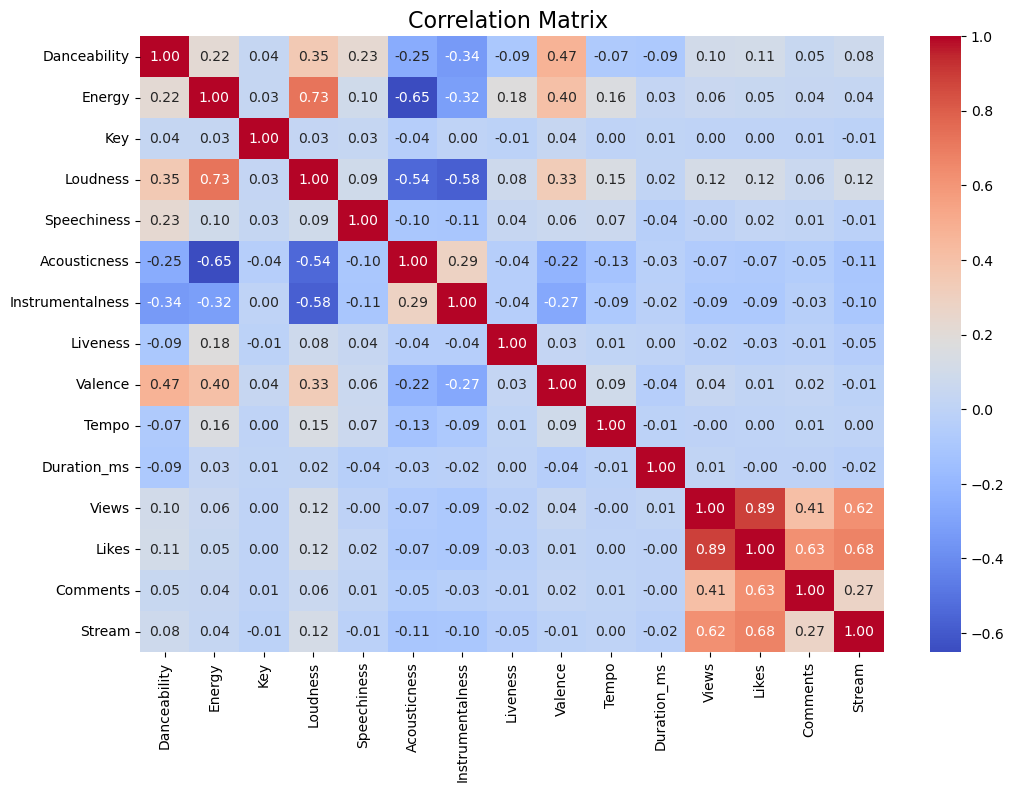

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
file_path = "clean_data.csv"
df = pd.read_csv(file_path)

# Choose specific columns (must be numeric for correlation)
selected_cols = ["Danceability", "Energy", "Key", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo", "Duration_ms", "Views", "Likes", "Comments", "Stream"]  
subset_df = df[selected_cols]

# Build correlation matrix
corr_matrix = subset_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix ", fontsize=16)
plt.show()


In [2]:
# VIF analysis for multicollinearity
# Requires: pandas, numpy, statsmodels

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices  # optional if you want to build X via formula

# --- Load data ---
file_path = "clean_data.csv"  # change if needed
df = pd.read_csv(file_path)

# --- 1) Choose features for VIF (numeric only recommended) ---
selected_cols = [
    "Danceability", "Energy", "Key", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo", "Duration_ms", "Views", "Likes", "Comments", "Stream",
    # add/remove columns as needed; must be numeric
]

X = df[selected_cols].copy()

# --- 2) Basic cleaning: drop rows with NA, remove constant columns ---
X = X.dropna(axis=0)  # or X.fillna(X.median()) if you prefer imputation

# remove near-constant columns (variance ~ 0)
const_like = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if const_like:
    print("Dropping constant/near-constant columns:", const_like)
    X = X.drop(columns=const_like)

# Add intercept for VIF computation (recommended)
X_with_const = X.assign(_const=1.0)

def compute_vif(df_features: pd.DataFrame) -> pd.DataFrame:
    """Compute a single-pass VIF table for df_features (expects an added intercept)."""
    cols = df_features.columns
    vif_list = []
    for i in range(len(cols)):
        # Skip the intercept column in reporting (but keep it in matrix)
        v = variance_inflation_factor(df_features.values, i)
        vif_list.append((cols[i], v))
    vif_df = pd.DataFrame(vif_list, columns=["feature", "VIF"])
    # remove intercept row if present
    vif_df = vif_df[vif_df["feature"] != "_const"].reset_index(drop=True)
    return vif_df.sort_values("VIF", ascending=False)

# --- 3) Single-pass VIF table ---
vif_table = compute_vif(X_with_const)
print("Single-pass VIF:")
print(vif_table)

# --- 4) Iterative VIF elimination ---
def vif_elimination(X_in: pd.DataFrame, vif_threshold: float = 10.0, verbose: bool = True):
    """
    Iteratively remove the feature with the highest VIF until all VIFs <= threshold.
    Returns the reduced DataFrame of features and the history of dropped columns.
    """
    X_curr = X_in.copy()
    dropped = []

    while True:
        Xc = X_curr.assign(_const=1.0)
        vif_df = compute_vif(Xc)

        max_vif = vif_df["VIF"].max()
        if np.isnan(max_vif):  # guard against degenerate cases
            break

        if max_vif <= vif_threshold:
            if verbose:
                print(f"All VIFs ≤ {vif_threshold}. Stopping.")
            break

        # feature with the highest VIF
        worst_feat = vif_df.loc[vif_df["VIF"].idxmax(), "feature"]
        dropped.append((worst_feat, float(max_vif)))
        if verbose:
            print(f"Dropping '{worst_feat}' with VIF={max_vif:.2f}")

        X_curr = X_curr.drop(columns=[worst_feat])

        # stop if only 1 feature left
        if X_curr.shape[1] <= 1:
            if verbose:
                print("Only one feature remains; stopping.")
            break

    # final VIFs
    final_vif = compute_vif(X_curr.assign(_const=1.0))
    return X_curr, pd.DataFrame(dropped, columns=["dropped_feature", "VIF_when_dropped"]), final_vif

# --- 5) Run iterative elimination (threshold commonly 5 or 10) ---
X_reduced, dropped_history, final_vif = vif_elimination(X, vif_threshold=10.0, verbose=True)

print("\nDropped features (in order):")
print(dropped_history if not dropped_history.empty else "None")

print("\nFinal features after VIF elimination:")
print(list(X_reduced.columns))

print("\nFinal VIF table:")
print(final_vif)


Single-pass VIF:
             feature       VIF
12             Likes  9.675920
11             Views  5.855227
1             Energy  3.246397
3           Loudness  3.147259
13          Comments  2.122553
14            Stream  2.021923
5       Acousticness  1.867274
0       Danceability  1.649915
6   Instrumentalness  1.623577
8            Valence  1.565905
4        Speechiness  1.090360
9              Tempo  1.069300
7           Liveness  1.067538
10       Duration_ms  1.016049
2                Key  1.005327
All VIFs ≤ 10.0. Stopping.

Dropped features (in order):
None

Final features after VIF elimination:
['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments', 'Stream']

Final VIF table:
             feature       VIF
12             Likes  9.675920
11             Views  5.855227
1             Energy  3.246397
3           Loudness  3.147259
13          Comments  2.12255